# IMDB Dataset Sentiment Analysis

The dataset contains IMDB movie reviews and is annotated wether it is a positive or a negative review. The task is to create a model, that can recognize if a review is good or bad. The dataset is taken from the Kaggle competetion that can be found [here](https://www.kaggle.com/columbine/imdb-dataset-sentiment-analysis-in-csv-format).

In [1]:
import tensorflow as tf
import tqdm
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
#%matplotlib inline
#plt.style.use( 'dark_background')

# Data Preprocessing

### Reading the data

Reading the data by skipping the first line (header), then reading it line by line, then caching it, shuffling it, setting the batch size to 64 and also prefetching it to reduce step time during training. 

In [2]:
def decode_line(line):
    return tf.io.decode_csv(line, record_defaults=[str(), int()])

train_data = tf.data.TextLineDataset('Train.csv') \
    .skip(1) \
    .map(decode_line) \
    .cache() \
    .shuffle(buffer_size=1024) \
    .batch(64) \
    .prefetch(tf.data.experimental.AUTOTUNE)
# Skip header
# Parse CSV file
# Cache file to disk for better performance
# Only training data is shuffled
# Preload a single batch at all times in the background

val_data = tf.data.TextLineDataset('Valid.csv') \
    .skip(1) \
    .map(decode_line) \
    .cache() \
    .batch(64) \
    .prefetch(tf.data.experimental.AUTOTUNE)

test_data = tf.data.TextLineDataset('Test.csv') \
    .skip(1) \
    .map(decode_line) \
    .cache() \
    .batch(64) \
    .prefetch(tf.data.experimental.AUTOTUNE)

x, y = next(iter(train_data))
x[0], y[0]

(<tf.Tensor: shape=(), dtype=string, numpy=b"A major disappointment. This was one of the best UK crime drama / detective shows from the 90's which developed the fascinating title character played by Scotland's Robbie Coltrane. However this one-off has little to add and perhaps suffers from an inevitable let down due to raised expectations when a favored show returns after a long hiatus. Coltrane isn't really given much to do, much more attention is spent on the uninteresting killer, and in what he has to act in, he seems uninvolved, almost bored. The ex-soldier's story is written by the books and the attempt to update us on Coltrane's family life seems lightweight. Perhaps if the writers had a whole series in front of them instead of just this one two-hour show they would have written this with much more depth. As is, skip this and watch the old Cracker from the 90's which is far far superior.">,
 <tf.Tensor: shape=(), dtype=int32, numpy=0>)

### Tokenizing and cleaning the sentences

The Tokenizer Class will remove all dots, all numbers, transform every word into lower case and then split every sentence into tokens for each word. 

In [3]:
class Tokenizer(tf.keras.layers.Layer):
    
    def __init__(self, name='Tokenizer'):
        super(Tokenizer, self).__init__(self, name=name)
    
    def call(self, text):
        # remove everything except words and spaces
        text = tf.strings.regex_replace(text, r'[^\w\s]', '')
        # remove digits
        text = tf.strings.regex_replace(text, r'\d', '')
        # all letters to lower case
        text = tf.strings.lower(text)
        # tokenize sentencese to single word tokens
        return tf.strings.split(text)

In [4]:
tokenizer = Tokenizer()

train_data = train_data.map(lambda x, y: (tokenizer(x), y))
val_data = val_data.map(lambda x, y: (tokenizer(x), y))
test_data = test_data.map(lambda x, y: (tokenizer(x), y))

x, y = next(iter(train_data))
x[0], y[0]

(<tf.Tensor: shape=(190,), dtype=string, numpy=
 array([b'this', b'film', b'concerns', b'a', b'very', b'young', b'girl',
        b'cassie', b'melissa', b'sagemiller', b'who', b'leaves', b'her',
        b'family', b'and', b'heads', b'off', b'to', b'become', b'a',
        b'college', b'freshman', b'one', b'night', b'cassie', b'and',
        b'her', b'friends', b'decide', b'to', b'go', b'to', b'a', b'wild',
        b'party', b'with', b'plenty', b'of', b'drinking', b'and',
        b'dancing', b'and', b'cassie', b'is', b'riding', b'with', b'her',
        b'boyfriend', b'who', b'she', b'likes', b'but', b'never', b'told',
        b'him', b'she', b'loved', b'him', b'as', b'cassie', b'was',
        b'driving', b'a', b'car', b'was', b'stopped', b'in', b'the',
        b'middle', b'of', b'the', b'road', b'and', b'she', b'was',
        b'unable', b'to', b'avoid', b'an', b'accident', b'and', b'as',
        b'a', b'result', b'there', b'is', b'a', b'bloody', b'loss', b'of',
        b'lives', b'along',

### Removing Stopwords

In [5]:
class StopwordFilter(tf.keras.layers.Layer):
    
    def __init__(self, sw, name='StopwordFilter'):
        super(StopwordFilter, self).__init__(self, name=name)
        
        remove_words_keys = tf.constant(sw, dtype=tf.string)
        remove_words_values = tf.fill([len(sw)], True)
        
        # Create a dict that maps a tf.string to True, if the string is in sw, else False
        stopwords_init = tf.lookup.KeyValueTensorInitializer(
                remove_words_keys, remove_words_values)
        self.stopwords_table = tf.lookup.StaticHashTable(
            stopwords_init, default_value=False)
    
    def call(self, words):
        is_stopword = tf.ragged.map_flat_values(
            self.stopwords_table.lookup, words)
        is_stopword = tf.cast(is_stopword, tf.bool)
        return tf.ragged.boolean_mask(words, ~is_stopword)

In [6]:
stopword_filter = StopwordFilter(stopwords.words('english'))

train_data = train_data.map(lambda x, y: (stopword_filter(x), y))
val_data = val_data.map(lambda x, y: (stopword_filter(x), y))
test_data = test_data.map(lambda x, y: (stopword_filter(x), y))

x, y = next(iter(train_data))
x[0], y[0]

(<tf.Tensor: shape=(100,), dtype=string, numpy=
 array([b'expected', b'something', b'great', b'went', b'see', b'bomb',
        b'basically', b'broadway', b'play', b'put', b'film', b'music',
        b'plain', b'terrible', b'isnt', b'one', b'memorable', b'song',
        b'movie', b'heard', b'hits', b'movie', b'wont', b'arent',
        b'musical', b'numbers', b'go', b'long', b'got', b'go', b'restroom',
        b'get', b'pop', b'corn', b'still', b'going', b'got', b'back',
        b'good', b'songs', b'well', b'suck', b'pace', b'slow', b'terrible',
        b'character', b'development', b'lead', b'praised', b'singing',
        b'sounded', b'like', b'screamed', b'every', b'song', b'almost',
        b'impossible', b'stand', b'movie', b'nothing', b'offer', b'anyone',
        b'diehard', b'broadway', b'enthusiasts', b'without', b'doubt',
        b'rated', b'movie', b'ive', b'seen', b'entire', b'life',
        b'complete', b'waist', b'time', b'money', b'nothing', b'memorable',
        b'movie', b'

### Feature Engineering

Each unique word will be transformed into an integer value. Therefore a vocabulary list of the data set needs to be created. 

In [7]:
class WordIndexer(tf.keras.layers.Layer):
    
    def __init__(self, vocab, name='WordIndexer'):
        super(WordIndexer, self).__init__(self, name=name)
        
        vocab_keys = tf.constant(sorted(list(vocab)), dtype=tf.string)
        vocab_values = tf.range(2, len(vocab_keys) + 2, dtype=tf.int64)
        
        # Create a dict that maps a tf.string to a unique index >= 2 for all of the strings in the vocab
        # else return 1, 0 is reserved for padding
        vocab_init = tf.lookup.KeyValueTensorInitializer(
            vocab_keys, vocab_values)
        self.vocab_table = tf.lookup.StaticHashTable(
            vocab_init, default_value=1)

    def call(self, words):
        return tf.ragged.map_flat_values(self.vocab_table.lookup, words)

In [8]:
vocab = set()
for x, y in tqdm.tqdm(train_data):
    vocab.update(word for text in x for word in text.numpy())

625it [01:50,  5.68it/s]


In [9]:
word_indexer = WordIndexer(vocab)

train_data = train_data.map(lambda x, y: (word_indexer(x), y))
val_data = val_data.map(lambda x, y: (word_indexer(x), y))
test_data = test_data.map(lambda x, y: (word_indexer(x), y))

x, y = next(iter(train_data))
x[0], y[0]

(<tf.Tensor: shape=(88,), dtype=int64, numpy=
 array([148691,  83921, 141212,  48461,  79844,  27613, 148403, 112775,
        135021,  83921,  56492,  32782,  16209,  83921,  68320,  29488,
        130864,  19394,  45249,  35571, 138149,  39677,  23571,  50473,
         64572, 135021,  79771, 152998,  78369, 118775,  11329,   6143,
         16397,  26892, 140933,  83921, 148944,  87993, 148403,  48333,
        119088,  89162,   9463,  16209,  84145,  66689,  74536,  22292,
         47551,  48501,  16397,  98867,  48461, 141212,  44427,  77792,
         70498,  85217,   9130,   1316,  66756,  83347,   7514,  64572,
        100761, 131116, 104191,  44199,  80885,  48461, 124856, 153165,
          1316,  44290, 120794,  24791,  23710,  81928,  70498,  79729,
         56032,  26767, 153165,  48461, 120794,  79593,  79593, 138858])>,
 <tf.Tensor: shape=(), dtype=int32, numpy=0>)

### Padding

The longest sentence in the data defines the input size, sentences with less words need to be padded and thus filled with zeros to match the input size. 

In [10]:
class Padder(tf.keras.layers.Layer):
    
    def __init__(self, input_size, name='Padder'):
        super(Padder, self).__init__(self, name=name)
        
        self.input_size = input_size

    def call(self, x):
        # Pad the ragged tensors with 0 to build a full tensor
        return x.to_tensor(default_value=0, shape=[None, self.input_size])

input_size = max(train_data.map(lambda x, y: x.bounding_shape()[1]))
padder = Padder(input_size)

train_data = train_data.map(lambda x, y: (padder(x), y))
val_data = val_data.map(lambda x, y: (padder(x), y))
test_data = test_data.map(lambda x, y: (padder(x), y))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [11]:
x, y = next(iter(train_data))
x, y

(<tf.Tensor: shape=(64, 1440), dtype=int64, numpy=
 array([[149651,  36433,  47770, ...,      0,      0,      0],
        [150557, 131489, 131298, ...,      0,      0,      0],
        [ 44824,  89686, 111313, ...,      0,      0,      0],
        ...,
        [143957, 145295,  54005, ...,      0,      0,      0],
        [153221,  35672, 140990, ...,      0,      0,      0],
        [  6925,  90985, 104747, ...,      0,      0,      0]])>,
 <tf.Tensor: shape=(64,), dtype=int32, numpy=
 array([0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1],
       dtype=int32)>)

# Model Definition

In [12]:
model = tf.keras.Sequential([
    tf.keras.Input([input_size,]),
    tf.keras.layers.Embedding(len(vocab) + 2, 4, input_length=input_size),
    tf.keras.layers.SeparableConv1D(4, kernel_size=7, padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling1D(pool_size=5, strides=4),
    tf.keras.layers.Conv1D(8, kernel_size=3, strides=2, padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv1D(16, kernel_size=3, strides=2, padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv1D(16, kernel_size=3, strides=2, padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Activation('sigmoid')])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1440, 4)           622600    
_________________________________________________________________
separable_conv1d (SeparableC (None, 1440, 4)           48        
_________________________________________________________________
activation (Activation)      (None, 1440, 4)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 359, 4)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 180, 8)            104       
_________________________________________________________________
activation_1 (Activation)    (None, 180, 8)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 90, 16)            4

# Training

In [13]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model_history = model.fit(train_data, validation_data=val_data, epochs=8)

Epoch 1/8
625/625 [==============================] - 38s 61ms/step - loss: 0.5440 - accuracy: 0.7074 - val_loss: 0.4184 - val_accuracy: 0.8118
Epoch 2/8
625/625 [==============================] - 37s 59ms/step - loss: 0.3252 - accuracy: 0.8673 - val_loss: 0.3696 - val_accuracy: 0.8360
Epoch 3/8
625/625 [==============================] - 37s 59ms/step - loss: 0.1749 - accuracy: 0.9369 - val_loss: 0.3466 - val_accuracy: 0.8810
Epoch 4/8
625/625 [==============================] - 37s 60ms/step - loss: 0.0852 - accuracy: 0.9732 - val_loss: 0.3998 - val_accuracy: 0.8752
Epoch 5/8
625/625 [==============================] - 38s 60ms/step - loss: 0.0401 - accuracy: 0.9892 - val_loss: 0.4868 - val_accuracy: 0.8708
Epoch 6/8
625/625 [==============================] - 36s 57ms/step - loss: 0.0195 - accuracy: 0.9957 - val_loss: 0.5648 - val_accuracy: 0.8708
Epoch 7/8
625/625 [==============================] - 35s 56ms/step - loss: 0.0116 - accuracy: 0.9978 - val_loss: 0.6493 - val_accuracy: 0.8656

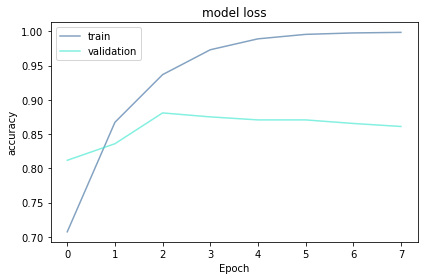

In [14]:
# Plotting the accuracy per epoch
plt.plot(model_history.history['accuracy'], color=(0.2, 0.4, 0.6, 0.6))
plt.plot(model_history.history['val_accuracy'], color=(0.2, 0.9, 0.8, 0.6))
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.gcf().patch.set_alpha(0.0)
plt.gca().patch.set_alpha(0.0)
plt.tight_layout()
plt.show()

In [15]:
model.evaluate(test_data)

79/79 [==============================] - 2s 24ms/step - loss: 0.7184 - accuracy: 0.8534


[0.7183563709259033, 0.8533999919891357]

# Full model exportation

In [16]:
# Create a model with the preprocessing pipeline
full_model = tf.keras.Sequential([
    tf.keras.layers.Input([], dtype=tf.string),
    tokenizer, stopword_filter, word_indexer, padder,
    model])

In [17]:
example_positive_review = 'This is one of the finest science fiction ' \
    'films ever made. Everything is so carefully and expertly constructed ' \
    'to the point that repeated viewings are just as good as the first. ' \
    'Also, the atmosphere, along with the amazing sets, is real shocker ' \
    'and few movies have managed to create the same kind eerie feeling.'
example_negative_review = 'I watch a lot of movies and I like to give them ' \
    'all a chance just in case there is something interesting or exciting to ' \
    'warrant a viewing Unfortunately this movie has none of these features it ' \
    'is pointless and offers nothing in the way of story line,acting or direction ' \
    'The plot is non-existent with the actors just going through the motions and ' \
    'the dialogue is sooo boring its embarrassing. I wish the previous reviewers ' \
    'had posted earlier as this would have saved me 95 mins of my time'
test_sentence = 'So good. Very good. Best movie ever! So cool.'
test2_sentence = 'I wish I could say: "So good. Very good. Best movie ever!' \
    ' So cool." But this is not the case. It was actually hard to watch.'
test3_sentence = 'Thanks for your attention!'

In [18]:
with np.printoptions(precision=3, suppress=True):
    print(full_model(tf.constant([example_positive_review, 
                                  example_negative_review,
                                  test_sentence, 
                                  test2_sentence, 
                                  test3_sentence])).numpy())

[[0.99 ]
 [0.   ]
 [0.979]
 [0.982]
 [0.977]]
